In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import clip
from torch.nn import functional as F
import torch.nn as nn
from torchvision import transforms
from PIL import Image
train = False
classes = None
pictures= None

def load_data():
    data_list = []
    label_list = []
    texts = []
    images = []
    
    if train:
        text_directory = "/home/ldy/Workspace/THINGS/images_set/training_images"  
    else:
        text_directory = "/home/ldy/Workspace/THINGS/images_set/test_images"
    dirnames = [d for d in os.listdir(text_directory) if os.path.isdir(os.path.join(text_directory, d))]
    dirnames.sort()
    
    if classes is not None:
        dirnames = [dirnames[i] for i in classes]

    for dir in dirnames:
        try:
            idx = dir.index('_')
        except ValueError:
            print(f"Skipped: {dir} due to no '_' found.")
            continue
            
        new_description = f"{description}"
        texts.append(new_description)

    if train:
    else:
        img_directory ="/home/ldy/Workspace/THINGS/images_set/test_images"
    
    all_folders = [d for d in os.listdir(img_directory) if os.path.isdir(os.path.join(img_directory, d))]

    if classes is not None and pictures is not None:
        for i in range(len(classes)):
            class_idx = classes[i]
            pic_idx = pictures[i]
            if class_idx < len(all_folders):
                folder = all_folders[class_idx]
                folder_path = os.path.join(img_directory, folder)
                all_images = [img for img in os.listdir(folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
                all_images.sort()
                if pic_idx < len(all_images):
                    images.append(os.path.join(folder_path, all_images[pic_idx]))
    elif classes is not None and pictures is None:
        for i in range(len(classes)):
            class_idx = classes[i]
            if class_idx < len(all_folders):
                folder = all_folders[class_idx]
                folder_path = os.path.join(img_directory, folder)
                all_images = [img for img in os.listdir(folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
                all_images.sort()
                images.extend(os.path.join(folder_path, img) for img in all_images)
    elif classes is None:
        for folder in all_folders:
            folder_path = os.path.join(img_directory, folder)
            all_images = [img for img in os.listdir(folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
            all_images.sort()  
            images.extend(os.path.join(folder_path, img) for img in all_images)
    else:
        print("Error")
    return texts, images
texts, images = load_data()
# images

In [2]:
texts

['aircraft_carrier',
 'antelope',
 'backscratcher',
 'balance_beam',
 'banana',
 'baseball_bat',
 'basil',
 'basketball',
 'bassoon',
 'baton4',
 'batter',
 'beaver',
 'bench',
 'bike',
 'birthday_cake',
 'blowtorch',
 'boat',
 'bok_choy',
 'bonnet',
 'bottle_opener',
 'brace',
 'bread',
 'breadbox',
 'bug',
 'buggy',
 'bullet',
 'bun',
 'bush',
 'calamari',
 'candlestick',
 'cart',
 'cashew',
 'cat',
 'caterpillar',
 'cd_player',
 'chain',
 'chaps',
 'cheese',
 'cheetah',
 'chest2',
 'chime',
 'chopsticks',
 'cleat',
 'cleaver',
 'coat',
 'cobra',
 'coconut',
 'coffee_bean',
 'coffeemaker',
 'cookie',
 'cordon_bleu',
 'coverall',
 'crab',
 'creme_brulee',
 'crepe',
 'crib',
 'croissant',
 'crow',
 'cruise_ship',
 'crumb',
 'cupcake',
 'dagger',
 'dalmatian',
 'dessert',
 'dragonfly',
 'dreidel',
 'drum',
 'duffel_bag',
 'eagle',
 'eel',
 'egg',
 'elephant',
 'espresso',
 'face_mask',
 'ferry',
 'flamingo',
 'folder',
 'fork',
 'freezer',
 'french_horn',
 'fruit',
 'garlic',
 'glove',


In [3]:
import os

import torch
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
# os.environ['http_proxy'] = 'http://10.16.35.10:13390' 
# os.environ['https_proxy'] = 'http://10.16.35.10:13390' 

os.environ["WANDB_API_KEY"] = "KEY"
os.environ["WANDB_MODE"] = 'offline'
from itertools import combinations

import clip
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import tqdm
from eegdatasets_leaveone import EEGDataset
from eegencoder import eeg_encoder
from einops.layers.torch import Rearrange, Reduce
from lavis.models.clip_models.loss import ClipLoss
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, Dataset
import random
from utils import wandb_logger
from torch import Tensor
import math


class PatchEmbedding(nn.Module):
    def __init__(self, emb_size=40):
        super().__init__()
        # revised from shallownet
        self.tsconv = nn.Sequential(
            nn.Conv2d(1, 40, (1, 25), (1, 1)),
            nn.AvgPool2d((1, 51), (1, 5)),
            nn.BatchNorm2d(40),
            nn.ELU(),
            nn.Conv2d(40, 40, (63, 1), (1, 1)),
            nn.BatchNorm2d(40),
            nn.ELU(),
            nn.Dropout(0.5),
        )

        self.projection = nn.Sequential(
            nn.Conv2d(40, emb_size, (1, 1), stride=(1, 1)),  
            Rearrange('b e (h) (w) -> b (h w) e'),
        )

    def forward(self, x: Tensor) -> Tensor:
        # b, _, _, _ = x.shape
        x = x.unsqueeze(1)     
        # print("x", x.shape)   
        x = self.tsconv(x)
        # print("tsconv", x.shape)   
        x = self.projection(x)
        # print("projection", x.shape)  
        return x


class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x


class FlattenHead(nn.Sequential):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x = x.contiguous().view(x.size(0), -1)
        return x


class Enc_eeg(nn.Sequential):
    def __init__(self, emb_size=40, **kwargs):
        super().__init__(
            PatchEmbedding(emb_size),
            FlattenHead()
        )

        
class Proj_eeg(nn.Sequential):
    def __init__(self, embedding_dim=1440, proj_dim=1024, drop_proj=0.5):
        super().__init__(
            nn.Linear(embedding_dim, proj_dim),
            ResidualAdd(nn.Sequential(
                nn.GELU(),
                nn.Linear(proj_dim, proj_dim),
                nn.Dropout(drop_proj),
            )),
            nn.LayerNorm(proj_dim),
        )


class Proj_img(nn.Sequential):
    def __init__(self, embedding_dim=1024, proj_dim=1024, drop_proj=0.3):
        super().__init__(
            nn.Linear(embedding_dim, proj_dim),
            ResidualAdd(nn.Sequential(
                nn.GELU(),
                nn.Linear(proj_dim, proj_dim),
                nn.Dropout(drop_proj),
            )),
            nn.LayerNorm(proj_dim),
        )
    def forward(self, x):
        return x 

class NICE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_eeg = Enc_eeg()
        self.proj_eeg = Proj_eeg()
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))
        self.loss_func = ClipLoss()        
    def forward(self, data):
        eeg_embedding = self.enc_eeg(data)
        out = self.proj_eeg(eeg_embedding)

        return out  
    

def get_eegfeatures(sub, eegmodel, dataloader, device, text_features_all, img_features_all, k, mode):
    eegmodel.eval()
    text_features_all = text_features_all.to(device).float()
    img_features_all = img_features_all.to(device).float()
    total_loss = 0
    correct = 0
    total = 0
    alpha =0.9
    top5_correct = 0
    top5_correct_count = 0
    all_labels = set(range(text_features_all.size(0)))
    top5_acc = 0
    mse_loss_fn = nn.MSELoss()
    ridge_lambda = 0.1
    save_features = True
    features_list = []  # List to store features    
    with torch.no_grad():
        for batch_idx, (eeg_data, labels, text, text_features, img, img_features) in enumerate(dataloader):
            eeg_data = eeg_data.to(device)
            eeg_data = eeg_data[:, :, :250]
            # print("eeg_data", eeg_data.shape)
            text_features = text_features.to(device).float()
            labels = labels.to(device)
            img_features = img_features.to(device).float()
            eeg_features = eegmodel(eeg_data).float()
            features_list.append(eeg_features)
            logit_scale = eegmodel.logit_scale 
                   
            regress_loss =  mse_loss_fn(eeg_features, img_features)
            # print("eeg_features", eeg_features.shape)
            # print(torch.std(eeg_features, dim=-1))
            # print(torch.std(img_features, dim=-1))
            # l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            # loss = (regress_loss + ridge_lambda * l2_norm)       
            img_loss = eegmodel.loss_func(eeg_features, img_features, logit_scale)
            text_loss = eegmodel.loss_func(eeg_features, text_features, logit_scale)
            contrastive_loss = img_loss
            # loss = img_loss + text_loss

            regress_loss =  mse_loss_fn(eeg_features, img_features)
            # print("text_loss", text_loss)
            # print("img_loss", img_loss)
            # print("regress_loss", regress_loss)            
            # l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            # loss = (regress_loss + ridge_lambda * l2_norm)       
            loss = alpha * regress_loss *10 + (1 - alpha) * contrastive_loss*10
            # print("loss", loss)
            total_loss += loss.item()
            
            for idx, label in enumerate(labels):
                possible_classes = list(all_labels - {label.item()})
                selected_classes = random.sample(possible_classes, k-1) + [label.item()]
                selected_img_features = img_features_all[selected_classes]
                
                logits_img = logit_scale * eeg_features[idx] @ selected_img_features.T
                # logits_text = logit_scale * eeg_features[idx] @ selected_text_features.T
                # logits_single = (logits_text + logits_img) / 2.0
                logits_single = logits_img
                # print("logits_single", logits_single.shape)
                # predicted_label = selected_classes[torch.argmax(logits_single).item()]
                predicted_label = selected_classes[torch.argmax(logits_single).item()] # (n_batch, ) \in {0, 1, ..., n_cls-1}
                if predicted_label == label.item():
                    correct += 1        
                total += 1

        if save_features:
            features_tensor = torch.cat(features_list, dim=0)
            print("features_tensor", features_tensor.shape)
            torch.save(features_tensor.cpu(), f"emb_eeg/{config['encoder_type']}_eeg_features_{sub}_{mode}.pt")  # Save features as .pt file
    average_loss = total_loss / (batch_idx+1)
    accuracy = correct / total
    return average_loss, accuracy, labels, features_tensor.cpu()

from IPython.display import Image, display
config = {
"data_path": "/home/ldy/Workspace/THINGS/Preprocessed_data_250Hz",
"project": "train_pos_img_text_rep",
"entity": "sustech_rethinkingbci",
"name": "lr=3e-4_img_pos_pro_eeg",
"lr": 3e-4,
"epochs": 50,
"batch_size": 1024,
"logger": True,
"encoder_type":'NICE',
}

device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
data_path = config['data_path']
emb_img_test = torch.load('variables/ViT-H-14_features_test.pt')
emb_img_train = torch.load('variables/ViT-H-14_features_train.pt')
eeg_model = NICE()
print('number of parameters:', sum([p.numel() for p in eeg_model.parameters()]))

#####################################################################################
# eeg_model.load_state_dict(torch.load("/home/ldy/Workspace/Reconstruction/models/contrast/sub-08/01-30_00-44/40.pth"))
eeg_model.load_state_dict(torch.load("/home/ldy/Workspace/BrainAligning_retrieval/models/contrast/NICE/sub-01/02-10_01-08/best.pth"))
eeg_model = eeg_model.to(device)
sub = 'sub-01'

#####################################################################################

test_dataset = EEGDataset(data_path, subjects= [sub], train=False)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=0)
text_features_test_all = test_dataset.text_features
img_features_test_all = test_dataset.img_features
test_loss, test_accuracy,labels, eeg_features_test = get_eegfeatures(sub, eeg_model, test_loader, device, text_features_test_all, img_features_test_all,k=200, mode="test")
print(f" - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

number of parameters: 2630913
self.subjects ['sub-01']
exclude_subject None
Data tensor shape: torch.Size([200, 63, 250]), label tensor shape: torch.Size([200]), text length: 200, image length: 200
features_tensor torch.Size([200, 1024])
 - Test Loss: 17.8302, Test Accuracy: 0.2050


In [4]:
#####################################################################################
train_dataset = EEGDataset(data_path, subjects= [sub], train=True)
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=0)
text_features_test_all = train_dataset.text_features
img_features_test_all = train_dataset.img_features

train_loss, train_accuracy, labels, eeg_features_train = get_eegfeatures(sub, eeg_model, train_loader, device, text_features_test_all, img_features_test_all,k=200, mode="train")
print(f" - Test Loss: {train_loss:.4f}, Test Accuracy: {train_accuracy:.4f}")
#####################################################################################

self.subjects ['sub-01']
exclude_subject None


data_tensor torch.Size([66160, 63, 250])
Data tensor shape: torch.Size([66160, 63, 250]), label tensor shape: torch.Size([66160]), text length: 1654, image length: 16540
features_tensor torch.Size([66160, 1024])
 - Test Loss: 13.4174, Test Accuracy: 0.0047


In [5]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import open_clip
from matplotlib.font_manager import FontProperties

import sys
from diffusion_prior import *
from custom_pipeline import *
# os.environ["CUDA_VISIBLE_DEVICES"] = "5" 
device = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')

In [6]:
emb_img_train_4 = emb_img_train.view(1654,10,1,1024).repeat(1,1,4,1).view(-1,1024)
emb_eeg = torch.load(f"/home/ldy/Workspace/Generation/emb_eeg/{config['encoder_type']}_eeg_features_{sub}_train.pt")
emb_eeg_test = torch.load(f"/home/ldy/Workspace/Generation/emb_eeg/{config['encoder_type']}_eeg_features_{sub}_test.pt")

In [7]:
emb_eeg.shape, emb_eeg_test.shape

(torch.Size([66160, 1024]), torch.Size([200, 1024]))

In [8]:
eeg_features_train

tensor([[-0.1670,  1.6152,  0.6006,  ..., -1.0451, -0.5136,  1.4004],
        [ 0.0806,  1.7924,  1.7227,  ...,  1.5857, -0.4999,  0.1480],
        [ 0.8228,  2.2548, -0.5258,  ...,  0.9890,  0.0443,  0.8686],
        ...,
        [ 0.4481, -1.3306,  1.6257,  ..., -0.7288, -1.7974,  0.0843],
        [-1.6263, -0.6156, -0.9117,  ..., -2.3007, -0.9201,  0.0390],
        [ 0.7418,  0.6952, -0.3310,  ...,  2.1147, -1.2884, -0.1144]])

In [9]:
from diffusion_prior import *
class EmbeddingDataset(Dataset):

    def __init__(self, c_embeddings=None, h_embeddings=None, h_embeds_uncond=None, cond_sampling_rate=0.5):
        self.c_embeddings = c_embeddings
        self.h_embeddings = h_embeddings
        self.N_cond = 0 if self.h_embeddings is None else len(self.h_embeddings)
        self.h_embeds_uncond = h_embeds_uncond
        self.N_uncond = 0 if self.h_embeds_uncond is None else len(self.h_embeds_uncond)
        self.cond_sampling_rate = cond_sampling_rate

    def __len__(self):
        return self.N_cond

    def __getitem__(self, idx):
        return {
            "c_embedding": self.c_embeddings[idx],
            "h_embedding": self.h_embeddings[idx]
        }

In [10]:
dataset = EmbeddingDataset(
    c_embeddings=eeg_features_train, h_embeddings=emb_img_train_4, 
    # h_embeds_uncond=h_embeds_imgnet
)
dl = DataLoader(dataset, batch_size=1024, shuffle=True, num_workers=64)
diffusion_prior = DiffusionPriorUNet(cond_dim=1024, dropout=0.1)
# number of parameters
print(sum(p.numel() for p in diffusion_prior.parameters() if p.requires_grad))
pipe = Pipe(diffusion_prior, device=device)

# load pretrained model
model_name = 'diffusion_prior' # 'diffusion_prior_vice_pre_imagenet' or 'diffusion_prior_vice_pre'
pipe.train(dl, num_epochs=150, learning_rate=1e-3) # to 0.142 

9675648
epoch: 0, loss: 1.1409468027261587
epoch: 1, loss: 0.9270567114536579
epoch: 2, loss: 0.731655058493981
epoch: 3, loss: 0.5862377469356244
epoch: 4, loss: 0.4814157105409182
epoch: 5, loss: 0.40168433097692635
epoch: 6, loss: 0.3466872655428373
epoch: 7, loss: 0.3165610561004052
epoch: 8, loss: 0.29713116884231566
epoch: 9, loss: 0.2808879737670605
epoch: 10, loss: 0.2699266507075383
epoch: 11, loss: 0.2584447269256298
epoch: 12, loss: 0.2503908198613387
epoch: 13, loss: 0.24116184688531436
epoch: 14, loss: 0.23339288303485284
epoch: 15, loss: 0.22835714198075807
epoch: 16, loss: 0.22227834325570325
epoch: 17, loss: 0.21636381928737347
epoch: 18, loss: 0.21179491602457487
epoch: 19, loss: 0.2072653460961122
epoch: 20, loss: 0.2060655259169065
epoch: 21, loss: 0.2023374046270664
epoch: 22, loss: 0.19921562511187332
epoch: 23, loss: 0.1961334858949368
epoch: 24, loss: 0.19505979533378895
epoch: 25, loss: 0.19182019600501427
epoch: 26, loss: 0.1909419018488664
epoch: 27, loss: 0.1

In [11]:

# pipe.diffusion_prior.load_state_dict(torch.load(f'./fintune_ckpts/{config['data_path']}/{sub}/{model_name}.pt', map_location=device))
save_path = f'./fintune_ckpts/{config["encoder_type"]}/{sub}/{model_name}.pt'

directory = os.path.dirname(save_path)

# Create the directory if it doesn't exist
os.makedirs(directory, exist_ok=True)
torch.save(pipe.diffusion_prior.state_dict(), save_path)
from PIL import Image
import os

# Assuming generator.generate returns a PIL Image
generator = Generator4Embeds(num_inference_steps=4, device=device)

directory = f"Generation/{config['encoder_type']}/generated_imgs/{sub}"
for k in range(200):
    eeg_embeds = emb_eeg_test[k:k+1]
    h = pipe.generate(c_embeds=eeg_embeds, num_inference_steps=50, guidance_scale=5.0)
    for j in range(1):
        image = generator.generate(h.to(dtype=torch.float16))
        # Construct the save path for each image
        path = f'{directory}/{texts[k]}/{j}.png'
        # Ensure the directory exists
        os.makedirs(os.path.dirname(path), exist_ok=True)
        # Save the PIL Image
        image.save(path)
        # print(f'Image saved to {path}')

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

50it [00:00, 257.28it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/aircraft_carrier/0.png


50it [00:00, 262.34it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/antelope/0.png


50it [00:00, 259.76it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/backscratcher/0.png


50it [00:00, 259.06it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/balance_beam/0.png


50it [00:00, 258.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/banana/0.png


50it [00:00, 261.97it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/baseball_bat/0.png


50it [00:00, 256.63it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/basil/0.png


50it [00:00, 254.67it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/basketball/0.png


50it [00:00, 257.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/bassoon/0.png


50it [00:00, 258.51it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/baton4/0.png


50it [00:00, 261.00it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/batter/0.png


50it [00:00, 261.60it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/beaver/0.png


50it [00:00, 257.27it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/bench/0.png


50it [00:00, 257.54it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/bike/0.png


50it [00:00, 255.39it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/birthday_cake/0.png


50it [00:00, 257.54it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/blowtorch/0.png


50it [00:00, 249.59it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/boat/0.png


50it [00:00, 253.61it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/bok_choy/0.png


50it [00:00, 256.07it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/bonnet/0.png


50it [00:00, 255.26it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/bottle_opener/0.png


50it [00:00, 255.87it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/brace/0.png


50it [00:00, 257.38it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/bread/0.png


50it [00:00, 254.43it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/breadbox/0.png


50it [00:00, 255.21it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/bug/0.png


50it [00:00, 253.88it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/buggy/0.png


50it [00:00, 129.99it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/bullet/0.png


50it [00:00, 252.82it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/bun/0.png


50it [00:00, 256.24it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/bush/0.png


50it [00:00, 253.19it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/calamari/0.png


50it [00:00, 257.04it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/candlestick/0.png


50it [00:00, 253.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/cart/0.png


50it [00:00, 256.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/cashew/0.png


50it [00:00, 256.73it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/cat/0.png


50it [00:00, 254.05it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/caterpillar/0.png


50it [00:00, 254.65it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/cd_player/0.png


50it [00:00, 254.41it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/chain/0.png


50it [00:00, 254.15it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/chaps/0.png


50it [00:00, 253.19it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/cheese/0.png


50it [00:00, 252.54it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/cheetah/0.png


50it [00:00, 253.97it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/chest2/0.png


50it [00:00, 254.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/chime/0.png


50it [00:00, 256.76it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/chopsticks/0.png


50it [00:00, 242.35it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/cleat/0.png


50it [00:00, 242.35it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/cleaver/0.png


50it [00:00, 252.54it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/coat/0.png


50it [00:00, 236.79it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/cobra/0.png


50it [00:00, 244.00it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/coconut/0.png


50it [00:00, 231.40it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/coffee_bean/0.png


50it [00:00, 244.58it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/coffeemaker/0.png


50it [00:00, 245.45it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/cookie/0.png


50it [00:00, 246.44it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/cordon_bleu/0.png


50it [00:00, 252.58it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/coverall/0.png


50it [00:00, 250.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/crab/0.png


50it [00:00, 238.21it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/creme_brulee/0.png


50it [00:00, 125.56it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/crepe/0.png


50it [00:00, 228.69it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/crib/0.png


50it [00:00, 239.82it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/croissant/0.png


50it [00:00, 254.28it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/crow/0.png


50it [00:00, 255.12it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/cruise_ship/0.png


50it [00:00, 254.01it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/crumb/0.png


50it [00:00, 256.92it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/cupcake/0.png


50it [00:00, 258.27it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/dagger/0.png


50it [00:00, 246.72it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/dalmatian/0.png


50it [00:00, 234.16it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/dessert/0.png


50it [00:00, 234.30it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/dragonfly/0.png


50it [00:00, 236.84it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/dreidel/0.png


50it [00:00, 241.51it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/drum/0.png


50it [00:00, 248.18it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/duffel_bag/0.png


50it [00:00, 239.90it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/eagle/0.png


50it [00:00, 243.52it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/eel/0.png


50it [00:00, 258.14it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/egg/0.png


50it [00:00, 260.00it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/elephant/0.png


50it [00:00, 257.01it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/espresso/0.png


50it [00:00, 256.89it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/face_mask/0.png


50it [00:00, 257.82it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/ferry/0.png


50it [00:00, 257.07it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/flamingo/0.png


50it [00:00, 255.51it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/folder/0.png


50it [00:00, 256.90it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/fork/0.png


50it [00:00, 256.30it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/freezer/0.png


50it [00:00, 258.32it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/french_horn/0.png


50it [00:00, 256.57it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/fruit/0.png


50it [00:00, 258.13it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/garlic/0.png


50it [00:00, 258.87it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/glove/0.png


50it [00:00, 256.12it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/golf_cart/0.png


50it [00:00, 257.40it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/gondola/0.png


50it [00:00, 145.50it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/goose/0.png


50it [00:00, 256.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/gopher/0.png


50it [00:00, 256.45it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/gorilla/0.png


50it [00:00, 252.45it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/grasshopper/0.png


50it [00:00, 254.87it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/grenade/0.png


50it [00:00, 252.65it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/hamburger/0.png


50it [00:00, 256.82it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/hammer/0.png


50it [00:00, 252.87it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/handbrake/0.png


50it [00:00, 257.96it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/headscarf/0.png


50it [00:00, 258.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/highchair/0.png


50it [00:00, 253.63it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/hoodie/0.png


50it [00:00, 254.36it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/hummingbird/0.png


50it [00:00, 257.66it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/ice_cube/0.png


50it [00:00, 254.60it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/ice_pack/0.png


50it [00:00, 254.60it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/jeep/0.png


50it [00:00, 240.59it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/jelly_bean/0.png


50it [00:00, 258.23it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/jukebox/0.png


50it [00:00, 251.97it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/kettle/0.png


50it [00:00, 252.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/kneepad/0.png


50it [00:00, 250.28it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/ladle/0.png


50it [00:00, 254.00it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/lamb/0.png


50it [00:00, 249.03it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/lampshade/0.png


50it [00:00, 256.30it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/laundry_basket/0.png


50it [00:00, 251.31it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/lettuce/0.png


50it [00:00, 254.58it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/lightning_bug/0.png


50it [00:00, 254.98it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/manatee/0.png


50it [00:00, 256.49it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/marijuana/0.png


50it [00:00, 251.01it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/meatloaf/0.png


50it [00:00, 242.65it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/metal_detector/0.png


50it [00:00, 243.12it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/minivan/0.png


50it [00:00, 256.61it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/modem/0.png


50it [00:00, 133.89it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/mosquito/0.png


50it [00:00, 254.93it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/muff/0.png


50it [00:00, 247.36it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/music_box/0.png


50it [00:00, 253.80it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/mussel/0.png


50it [00:00, 257.02it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/nightstand/0.png


50it [00:00, 253.24it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/okra/0.png


50it [00:00, 248.48it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/omelet/0.png


50it [00:00, 253.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/onion/0.png


50it [00:00, 255.66it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/orange/0.png


50it [00:00, 251.79it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/orchid/0.png


50it [00:00, 251.35it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/ostrich/0.png


50it [00:00, 247.14it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/pajamas/0.png


50it [00:00, 251.16it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/panther/0.png


50it [00:00, 253.01it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/paperweight/0.png


50it [00:00, 253.46it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/pear/0.png


50it [00:00, 254.56it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/pepper1/0.png


50it [00:00, 256.00it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/pheasant/0.png


50it [00:00, 253.72it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/pickax/0.png


50it [00:00, 256.48it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/pie/0.png


50it [00:00, 252.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/pigeon/0.png


50it [00:00, 253.84it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/piglet/0.png


50it [00:00, 249.90it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/pocket/0.png


50it [00:00, 255.68it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/pocketknife/0.png


50it [00:00, 251.16it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/popcorn/0.png


50it [00:00, 253.03it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/popsicle/0.png


50it [00:00, 254.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/possum/0.png


50it [00:00, 252.06it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/pretzel/0.png


50it [00:00, 250.62it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/pug/0.png


50it [00:00, 252.45it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/punch2/0.png


50it [00:00, 250.86it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/purse/0.png


50it [00:00, 252.90it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/radish/0.png


50it [00:00, 135.85it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/raspberry/0.png


50it [00:00, 253.30it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/recorder/0.png


50it [00:00, 252.09it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/rhinoceros/0.png


50it [00:00, 248.63it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/robot/0.png


50it [00:00, 237.92it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/rooster/0.png


50it [00:00, 248.23it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/rug/0.png


50it [00:00, 251.65it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/sailboat/0.png


50it [00:00, 231.38it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/sandal/0.png


50it [00:00, 229.14it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/sandpaper/0.png


50it [00:00, 247.77it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/sausage/0.png


50it [00:00, 248.81it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/scallion/0.png


50it [00:00, 235.39it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/scallop/0.png


50it [00:00, 246.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/scooter/0.png


50it [00:00, 249.80it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/seagull/0.png


50it [00:00, 234.89it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/seaweed/0.png


50it [00:00, 221.14it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/seed/0.png


50it [00:00, 243.32it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/skateboard/0.png


50it [00:00, 244.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/sled/0.png


50it [00:00, 238.73it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/sleeping_bag/0.png


50it [00:00, 249.67it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/slide/0.png


50it [00:00, 251.20it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/slingshot/0.png


50it [00:00, 239.64it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/snowshoe/0.png


50it [00:00, 218.28it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/spatula/0.png


50it [00:00, 249.57it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/spoon/0.png


50it [00:00, 250.61it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/station_wagon/0.png


50it [00:00, 234.73it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/stethoscope/0.png


50it [00:00, 240.07it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/strawberry/0.png


50it [00:00, 239.61it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/submarine/0.png


50it [00:00, 240.94it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/suit/0.png


50it [00:00, 231.71it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/t-shirt/0.png


50it [00:00, 243.39it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/table/0.png


50it [00:00, 118.91it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/taillight/0.png


50it [00:00, 242.18it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/tape_recorder/0.png


50it [00:00, 239.55it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/television/0.png


50it [00:00, 238.93it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/tiara/0.png


50it [00:00, 242.05it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/tick/0.png


50it [00:00, 240.12it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/tomato_sauce/0.png


50it [00:00, 246.33it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/tongs/0.png


50it [00:00, 220.54it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/tool/0.png


50it [00:00, 243.71it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/top_hat/0.png


50it [00:00, 230.26it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/treadmill/0.png


50it [00:00, 233.54it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/tube_top/0.png


50it [00:00, 248.71it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/turkey/0.png


50it [00:00, 246.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/unicycle/0.png


50it [00:00, 234.41it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/vise/0.png


50it [00:00, 236.14it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/volleyball/0.png


50it [00:00, 242.29it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/wallpaper/0.png


50it [00:00, 249.39it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/walnut/0.png


50it [00:00, 236.26it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/wheat/0.png


50it [00:00, 231.14it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/wheelchair/0.png


50it [00:00, 248.96it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/windshield/0.png


50it [00:00, 228.79it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/wine/0.png


50it [00:00, 243.09it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to Generation/NICE/generated_imgs/sub-01/wok/0.png


In [12]:
# import os
# # os.environ['http_proxy'] = 'http://10.16.35.10:13390' 
# # os.environ['https_proxy'] = 'http://10.16.35.10:13390' 
# # os.environ["CUDA_VISIBLE_DEVICES"] = "5" 
# # os.environ['PATH'] += os.pathsep + '/usr/local/texlive/2023/bin/x86_64-linux'

# import torch
# from torch import nn
# import torch.nn.functional as F
# import torchvision.transforms as transforms
# import matplotlib.pyplot as plt
# import open_clip
# from matplotlib.font_manager import FontProperties

# import sys
# from diffusion_prior import *
# from custom_pipeline import *

# device = torch.device('cuda:5' if torch.cuda.is_available() else 'cpu')

Load eeg and image embeddings

In [13]:
# # load image embeddings
# data = torch.load('/home/ldy/Workspace/THINGS/CLIP/ViT-H-14_features_test.pt', map_location='cuda:3')
# emb_img_test = data['img_features']

# # load image embeddings
# data = torch.load('/home/ldy/Workspace/THINGS/CLIP/ViT-H-14_features_train.pt', map_location='cuda:3')
# emb_img_train = data['img_features']

In [14]:
# emb_img_test = torch.load('variables/ViT-H-14_features_test.pt')
# emb_img_train = torch.load('variables/ViT-H-14_features_train.pt')

# torch.save(emb_img_test.cpu().detach(), 'variables/ViT-H-14_features_test.pt')
# torch.save(emb_img_train.cpu().detach(), 'variables/ViT-H-14_features_train.pt')

In [15]:
# emb_img_test.shape, emb_img_train.shape

In [16]:
# 1654clsx10imgsx4trials=66160
# emb_eeg = torch.load('/home/ldy/Workspace/Reconstruction/ATM_S_eeg_features_sub-08.pt')

# emb_eeg_test = torch.load('/home/ldy/Workspace/Reconstruction/ATM_S_eeg_features_sub-08_test.pt')

In [17]:
# emb_eeg.shape, emb_eeg_test.shape

Training prior diffusion

In [18]:

class EmbeddingDataset(Dataset):

    def __init__(self, c_embeddings=None, h_embeddings=None, h_embeds_uncond=None, cond_sampling_rate=0.5):
        self.c_embeddings = c_embeddings
        self.h_embeddings = h_embeddings
        self.N_cond = 0 if self.h_embeddings is None else len(self.h_embeddings)
        self.h_embeds_uncond = h_embeds_uncond
        self.N_uncond = 0 if self.h_embeds_uncond is None else len(self.h_embeds_uncond)
        self.cond_sampling_rate = cond_sampling_rate

    def __len__(self):
        return self.N_cond

    def __getitem__(self, idx):
        return {
            "c_embedding": self.c_embeddings[idx],
            "h_embedding": self.h_embeddings[idx]
        }

In [19]:
emb_img_train_4 = emb_img_train.view(1654,10,1,1024).repeat(1,1,4,1).view(-1,1024)

In [20]:
emb_img_train_4.shape

torch.Size([66160, 1024])

In [21]:
# path_data = '/mnt/dataset0/weichen/projects/visobj/proposals/mise/data'
# image_features = torch.load(os.path.join(path_data, 'openclip_emb/emb_imgnet.pt')) # 'emb_imgnet' or 'image_features'
# h_embeds_imgnet = image_features['image_features']

In [22]:
from torch.utils.data import DataLoader
dataset = EmbeddingDataset(
    c_embeddings=emb_eeg, h_embeddings=emb_img_train_4, 
    # h_embeds_uncond=h_embeds_imgnet
)
print(len(dataset))
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True, num_workers=64)

66160


In [23]:
# diffusion_prior = DiffusionPrior(dropout=0.1)
diffusion_prior = DiffusionPriorUNet(cond_dim=1024, dropout=0.1)
# number of parameters
print(sum(p.numel() for p in diffusion_prior.parameters() if p.requires_grad))
pipe = Pipe(diffusion_prior, device=device)

9675648


In [24]:
# load pretrained model
model_name = 'diffusion_prior' # 'diffusion_prior_vice_pre_imagenet' or 'diffusion_prior_vice_pre'
pipe.diffusion_prior.load_state_dict(torch.load(f"./fintune_ckpts/{config['encoder_type']}/{sub}/{model_name}.pt", map_location=device))
# pipe.train(dataloader, num_epochs=150, learning_rate=1e-3) # to 0.142 

<All keys matched successfully>

In [25]:
# save model
# torch.save(pipe.diffusion_prior.state_dict(), f'./ckpts/{model_name}.pt')

Generating by eeg embeddings

In [26]:
# save model
# torch.save(pipe.diffusion_prior.state_dict(), f'./ckpts/{model_name}.pt')
from IPython.display import Image, display
generator = Generator4Embeds(num_inference_steps=4, device=device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

image_embeds torch.Size([1, 1024])


  0%|          | 0/4 [00:00<?, ?it/s]

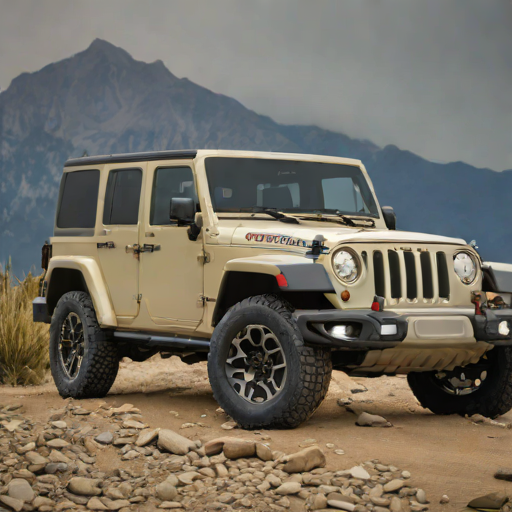

In [27]:
# path of ground truth: /home/ldy/Workspace/THINGS/images_set/test_images
k = 99
image_embeds = emb_img_test[k:k+1]
print("image_embeds", image_embeds.shape)
image = generator.generate(image_embeds)
display(image)

In [28]:
# image_embeds = emb_eeg_test[k:k+1]
# print("image_embeds", image_embeds.shape)
# image = generator.generate(image_embeds)
# display(image)

Generating by eeg informed image embeddings

image_embeds torch.Size([1, 1024])


50it [00:00, 235.45it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

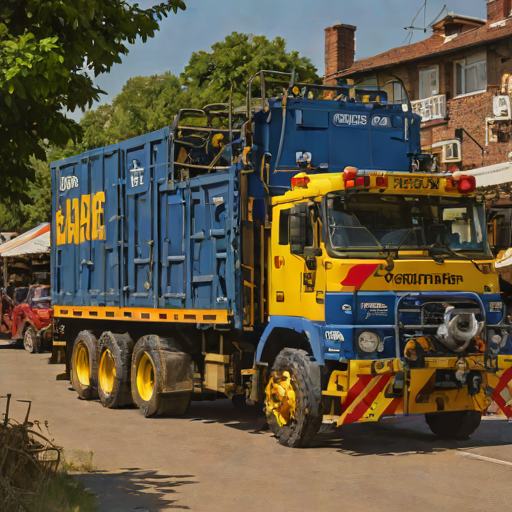

In [29]:
# k = 0
eeg_embeds = emb_eeg_test[k:k+1]
print("image_embeds", eeg_embeds.shape)
h = pipe.generate(c_embeds=eeg_embeds, num_inference_steps=50, guidance_scale=5.0)
image = generator.generate(h.to(dtype=torch.float16))
display(image)